inspiration = https://medium.com/analytics-vidhya/building-a-technical-analysis-chart-with-python-17107b78b297

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import talib
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
import yfinance as yf

In [3]:
# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date ten years ago as UTC timestamp
ten_yr_ago = today-relativedelta(years=10)
fro = int(ten_yr_ago.timestamp())

In [4]:
print(to)

1624665600


In [5]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

In [6]:
def get_indicators(data):

    #Get MACD
    data['macd'], data['macd_signal'], data['macd_hist'] = talib.MACD(data['Close'])

    #Get MA10 and MA30
    data['ma10'] = talib.MA(data['Close'], timeperiod=10)
    data['ma30'] = talib.MA(data['Close'], timeperiod=30)

    #Get RSI
    data['rsi'] = talib.RSI(data['Close'])

    return data

In [7]:
def plot_chart(data, n, ticker):
    # Filter number of obserbations to plot
    data = data.iloc[-n:]

    #Create fituer and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20,16))
    ax_candle = fig.add_axes((0, 0.72, 1,0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0,0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)

    #Format x-axis ticks as dates
    ax_candle.xaxis_date()

    #Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])

    #Plot candlestick chart
    ax_candle.plot(data.index, data['ma10'], label='MA10')
    ax_candle.plot(data.index, data['ma30'], label='MA30')
    candlestick_ohlc(ax_candle, ohlc, colorup='g', colordown='r', width=0.8)
    ax_candle.legend()

    #Plot MACD 
    ax_macd.plot(data.index, data['macd'], label='macd')
    ax_macd.bar(data.index, data['macd_hist'] * 3,label='macd', color=(data['macd_hist'] > 0).map({True: 'g',      False: 'r'}))
    ax_macd.plot(data.index, data['macd_signal'],label='signal')
    ax_macd.legend()
    
    #Plot RSI 
    # Above 70% = overbough, below 30% = oversold
    ax_rsi.set_ylabel("(%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label = 'overbought')
    ax_rsi.plot(data.index, [30] * len(data.index), label= 'oversold')
    ax_rsi.plot(data.index, data['rsi'], label='rsi')
    ax_rsi.legend()

    #Show volume in millions
    ax_vol.bar(data.index, data['Volume']/1000000)
    ax_vol.set_ylabel("(Million)")

    #Save the chart as PNG 
    fig.savefig('charts/'+ ticker +'.png', bbox_inches='tight')

    plt.show()

In [20]:
def stock(ticker='AAPL', period=180):
    df = get_price_hist(ticker)
    df2 = get_indicators(df)
    plot_chart(df2, period, ticker)

In [19]:
sbux_df = get_price_hist('SBUX')
sbux_df2 = get_indicators(sbux_df)

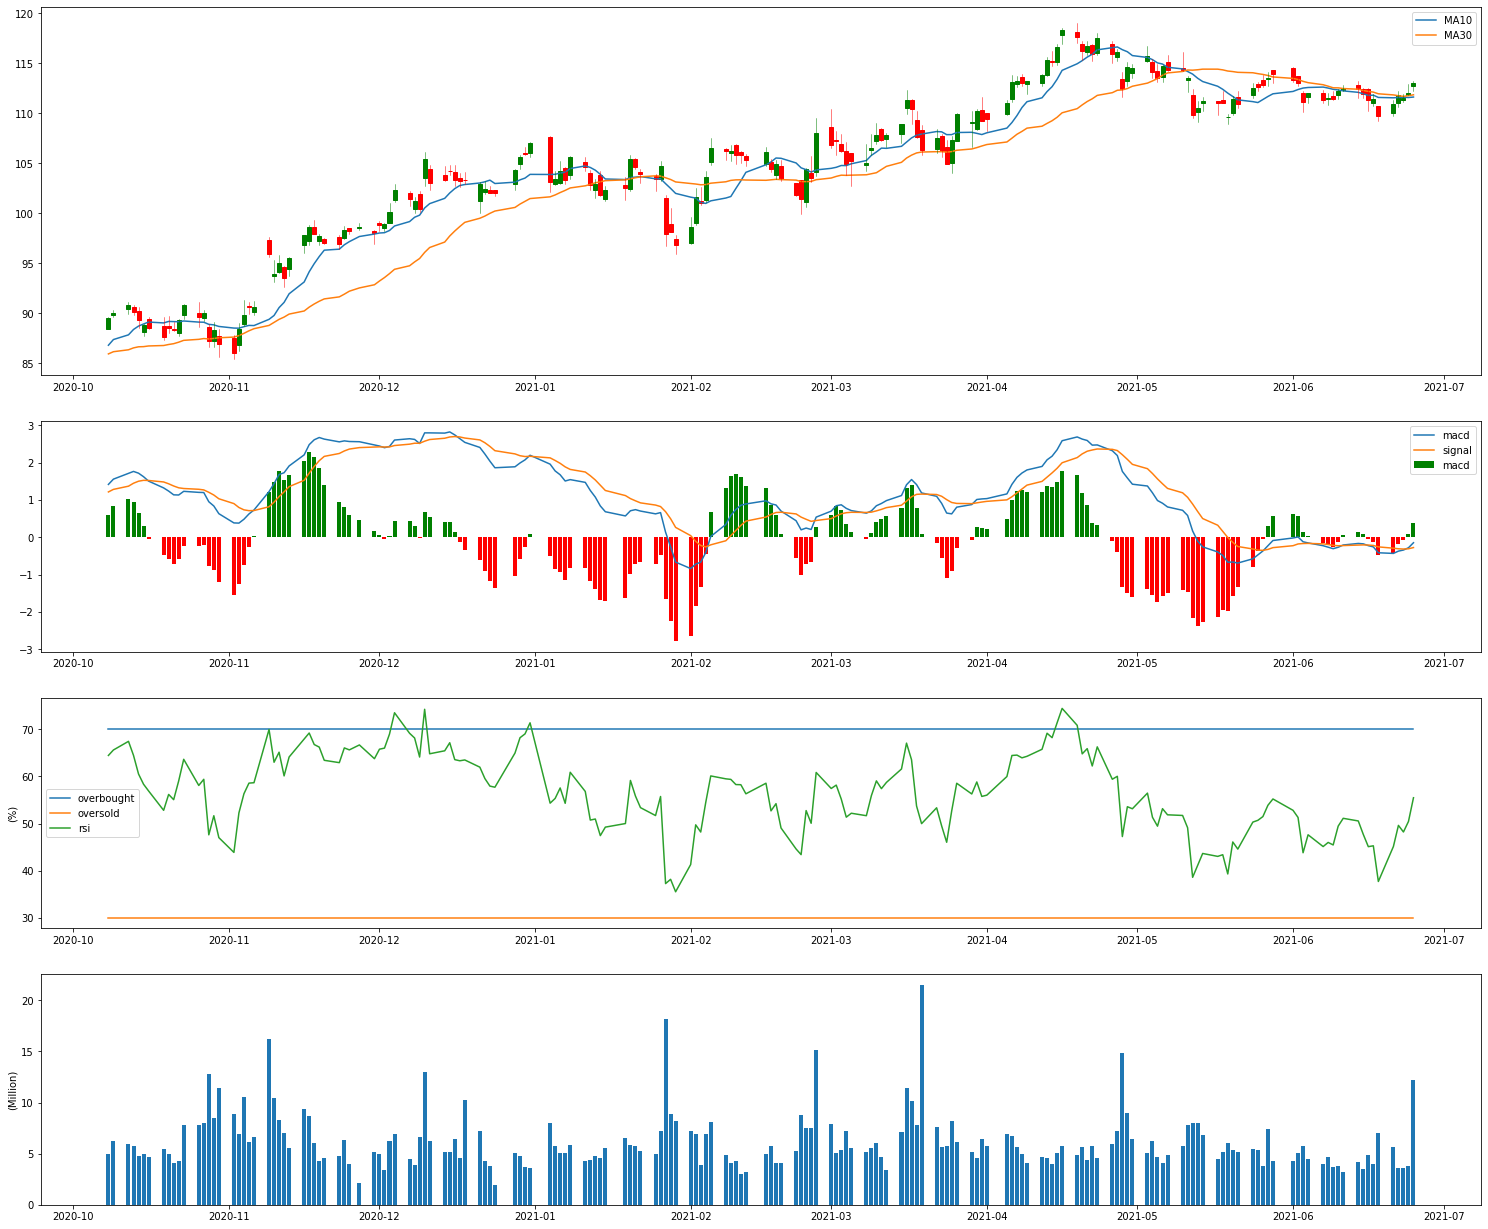

In [27]:
plot_chart(sbux_df2, 180, 'SBUX')